<p style="padding: 10px;
          color:#000000;
          font-weight: bold;
          text-align: center;
          background-color:#FFFFFF;
          font-size:200%;">
Freight Price Predictions
    </p>

## Import Libraries

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import os
from os import path
home = path.abspath(path.join("__file__",".."))
print(home)

# for visualization: plotly
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objects as go
# import plotly.express as px
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import iplot

# for building the model and calculate RMSE
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

/Users/anniecondon/Documents/coyote_take_home


## Import Data

In [264]:
train = pd.read_csv("newassign_trn.csv")
test = pd.read_csv("newassign_val.csv")

In [265]:
print(f"Shape of training data is {train.shape} and the shape of the test set is {test.shape}")

Shape of training data is (5000, 10) and the shape of the test set is (1000, 10)


In [266]:
#train.head()

In [267]:
#test.head()

In [268]:
#train.columns

In [269]:
#test.columns

In [270]:
train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
Id,5000.000000,22363180.034400,128367.032685,20679807.000000,22275586.500000,22349808.000000,22464223.500000,22838571.000000
OriginLatitude,5000.000000,37.077210,5.095390,26.000000,33.067500,39.510000,41.830000,43.920000
OriginLongitude,5000.000000,-91.055846,5.744188,-106.000000,-96.370000,-89.060000,-87.050000,-80.000000
DestinationLatitude,5000.000000,36.580376,5.134062,26.000000,32.350000,38.890000,41.390000,43.960000
DestinationLongitude,5000.000000,-91.163906,6.252240,-106.000000,-96.580000,-90.670000,-85.710000,-80.000000
Miles,5000.000000,427.177600,412.294764,-1.000000,178.000000,281.000000,491.000000,2778.000000
NumStops,5000.000000,2.096200,0.473065,2.000000,2.000000,2.000000,2.000000,12.000000
Price,5000.000000,1207.708000,856.386319,100.000000,571.750000,950.000000,1600.000000,7300.000000
HazMat,5000.000000,0.017600,0.131506,0.000000,0.000000,0.000000,0.000000,1.000000


## EDA

### Missing Values

I start by looking for missing values in the data. Fortunately, there are none, except for the missing price predictions in the test set, which I will fill in later.

In [271]:
cols_with_missing = [col for col in train.columns 
                                 if train[col].isnull().any()]
miss_count =train.isnull().sum()
miss_df = (pd.concat([miss_count.rename('Missing count'),miss_count.div(len(train)).rename('% Missing')],axis = 1).loc[miss_count.ne(0)])
print("Training Set:")
display(miss_df.style.background_gradient(cmap="coolwarm"))

cols_with_missing = [col for col in test.columns 
                                 if test[col].isnull().any()]
miss_count =test.isnull().sum()
miss_df = (pd.concat([miss_count.rename('Missing count'),miss_count.div(len(test)).rename('% Missing')],axis = 1).loc[miss_count.ne(0)])
print("Test Set:")
miss_df.style.background_gradient(cmap="coolwarm")

Training Set:


,Missing count,% Missing


Test Set:


,Missing count,% Missing
Price,1000,1.000000


### Target Variable

Next, I take a look at the target variable, "Price". This graph is positively skewed and has a long right side tail. This means that the median price is ~1,000, but there are many outliers of much higher priced lines. Because "Price" has many outliers, we will want to use mean absolute error to assess our model, because that will provide a robust metric to assess the error.

<AxesSubplot:xlabel='Price'>

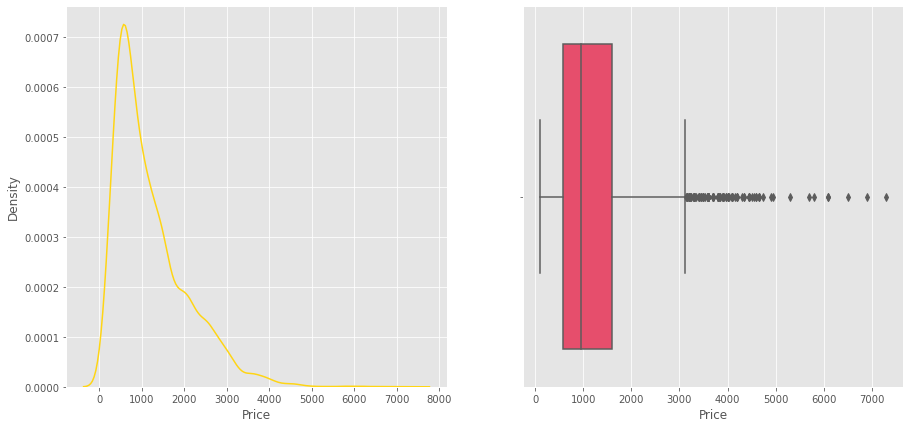

In [272]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.kdeplot(train.Price , color = "#ffd514")
plt.subplot(122)
sns.boxplot(train.Price , color = "#ff355d")

In [273]:
train['Price'].describe()

count    5000.000000
mean     1207.708000
std       856.386319
min       100.000000
25%       571.750000
50%       950.000000
75%      1600.000000
max      7300.000000
Name: Price, dtype: float64

### Categorical Data

There are no cateogorical features. There is a date of pickup, from which we can extract the season,the month, the day of the week, and whether or not it's the weekend.

In [274]:
train.dtypes

Id                        int64
OriginLatitude          float64
OriginLongitude         float64
DestinationLatitude     float64
DestinationLongitude    float64
Miles                   float64
NumStops                  int64
Price                   float64
HazMat                    int64
Pickup                   object
dtype: object

In [275]:
# create seasonality features
train['Pickup'] = pd.to_datetime(train['Pickup'])
test['Pickup'] = pd.to_datetime(test['Pickup'])

In [276]:
# add month, day of week, day of month and hour
train['month'] = train['Pickup'].dt.month.astype(np.int8)
train['day_of_week'] = train['Pickup'].dt.dayofweek.astype(np.int8)
train['day_of_month']= train['Pickup'].dt.day.astype(np.int8)
train['hour'] = train['Pickup'].dt.hour

# add is weekend column
train['is_weekend'] = train.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [277]:
# add month, day of week, day of month and hour
test['month'] = test['Pickup'].dt.month.astype(np.int8)
test['day_of_week'] = test['Pickup'].dt.dayofweek.astype(np.int8)
test['day_of_month']= test['Pickup'].dt.day.astype(np.int8)
test['hour'] = test['Pickup'].dt.hour

# add is weekend column
test['is_weekend'] = test.day_of_week.apply(lambda x: 1 if x>=5 else 0)

### Numeric Data

There are ~12 variables we can treat as numeric, not including the target variable, "Price."

In [278]:
numerical_cols = train.select_dtypes(exclude='object').columns
numerical_cols

Index(['Id', 'OriginLatitude', 'OriginLongitude', 'DestinationLatitude',
       'DestinationLongitude', 'Miles', 'NumStops', 'Price', 'HazMat',
       'Pickup', 'month', 'day_of_week', 'day_of_month', 'hour', 'is_weekend'],
      dtype='object')

I check the distributions of the input variables to see if they are normal. Most of the distributions are either skewed, bi-modal, or multi-modal. If I were to spend more time on this, I may make some transformations to these inputs so that they are normally distributed.

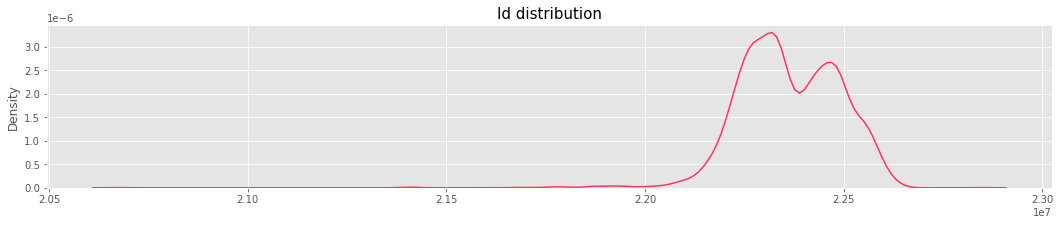

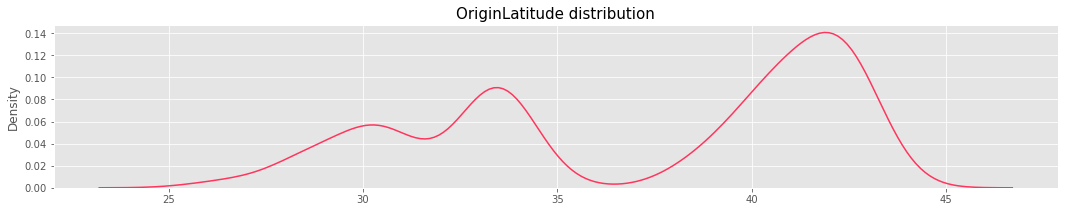

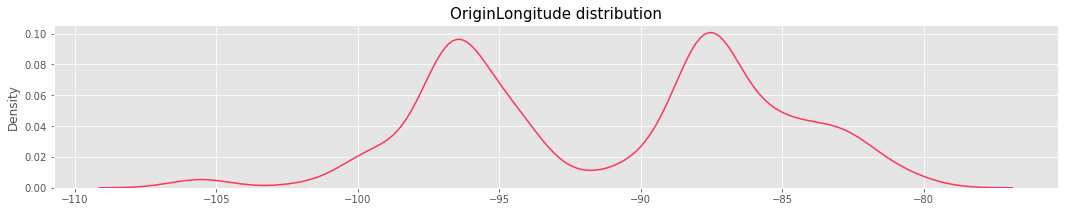

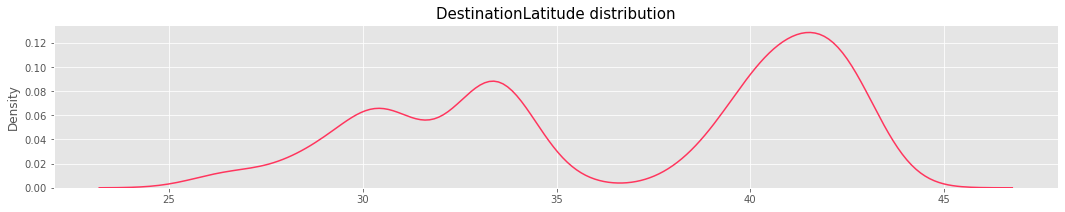

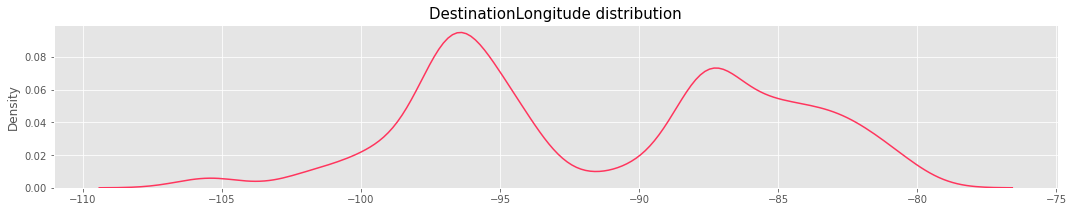

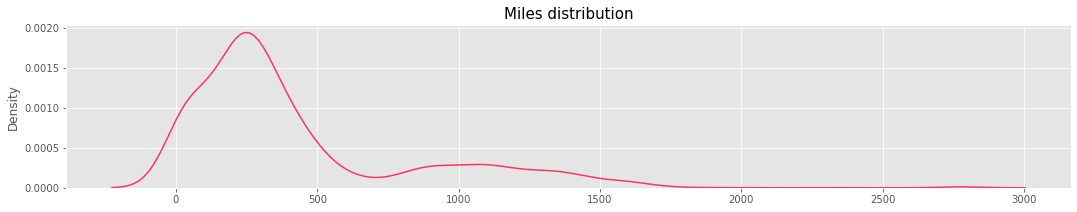

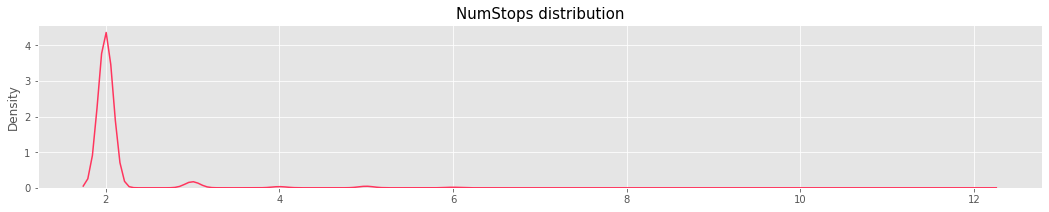

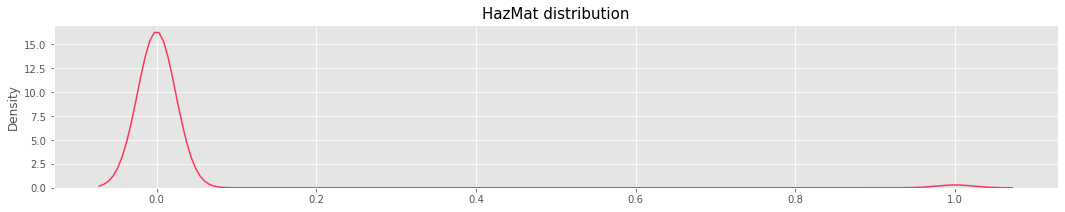

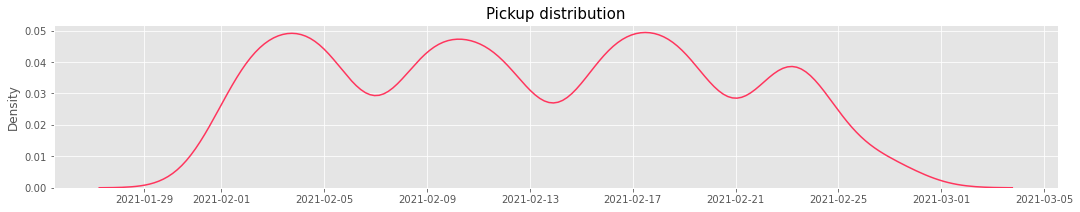

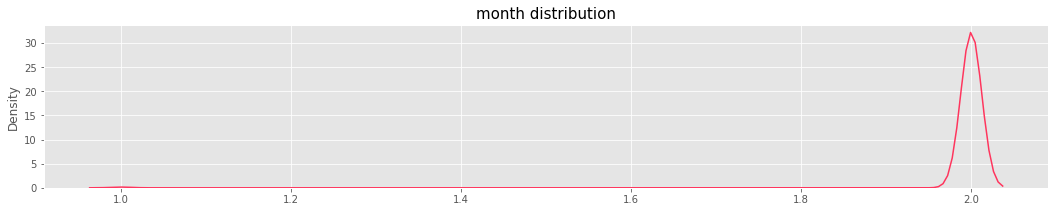

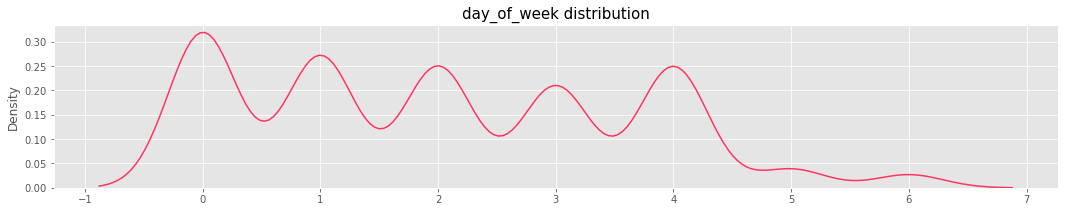

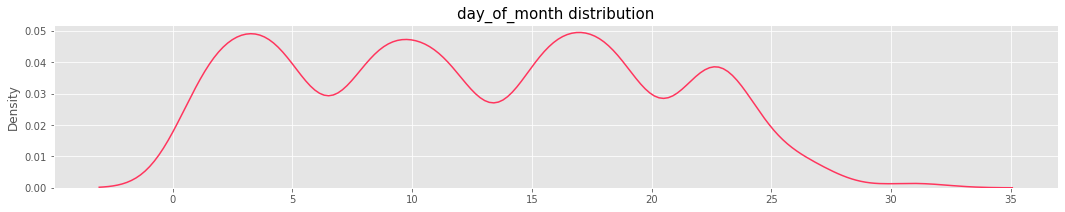

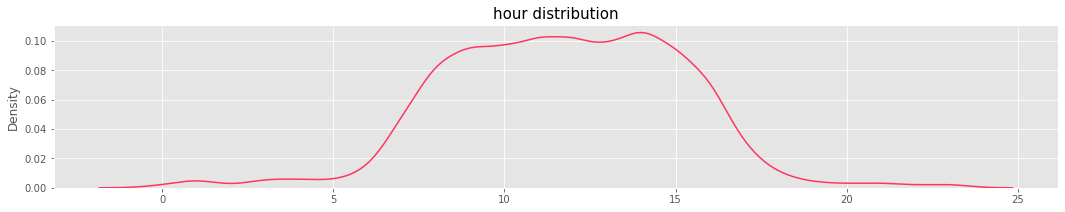

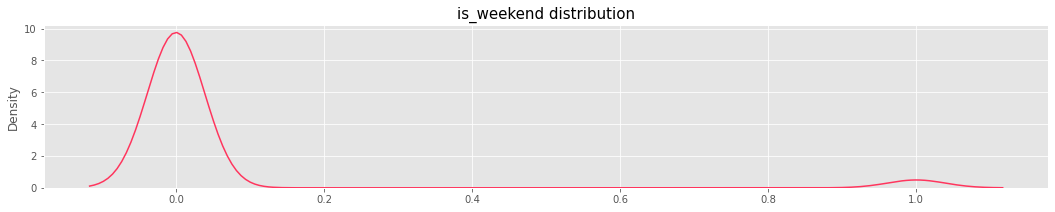

In [279]:
# plot distributions of features
for feature in numerical_cols:
    if feature != "Price":
        train_values = train[feature].to_numpy() 

        plt.figure(figsize = (18, 3))

        sns.kdeplot(train_values, color = '#ff355d')

        plt.title(feature+' distribution', fontsize=15)
        plt.show();

        del train_values

### Correlation Analysis

A correlation analysis using a Pearson's correlation test reveals that "Miles" has the highest correlation with price, which makes sense, because the longer the distance, the more costly the load. Based on the Pearson's correlation, there is only slight correlation (0.30) between the other input variables and "Price." 

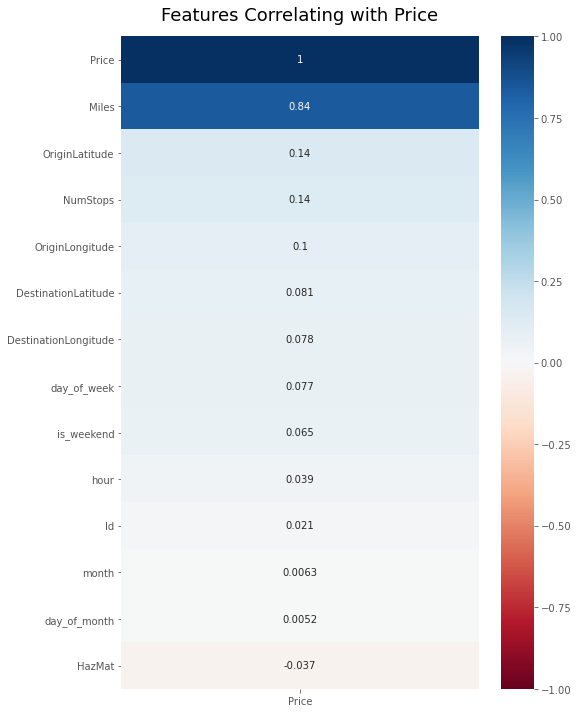

In [280]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

In [281]:
#train.columns

In [282]:
# fig = px.scatter_matrix(train,
#                         dimensions=['OriginLatitude', 
#                                     'OriginLongitude', 
#                                     'DestinationLatitude',
#                                     'DestinationLongitude', 
#                                     'Miles', 
#                                     'NumStops', 
#                                     'Price', 
#                                     'HazMat',
#                                     'Pickup', 
#                                     'month', 
#                                     'day_of_week', 
#                                     'day_of_month',
#                                     'hour', 
#                                     'is_weekend'],
#                         color="Price")

# fig.update_layout(
#     title='Input Variables and Price',
#     dragmode='select',
#     width=1400,
#     height=1400,
#     hovermode='closest')

# fig.update_traces(diagonal_visible=True)
# fig.show()

### Feature Selection

In this section, I remove input variables from the training data that have a correlation with "Price that is less than 0.10. However, I did not end up using this training data set because it performed worse than when I trained the model using all of the inputs.

In [283]:
correlations_transformed = pd.DataFrame(train.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["Price"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with price"]
corr_df = (correlations_transformed[correlations_transformed["Feature"] != "Price"]
                .sort_values(by="Correlation with price", ascending=True))
corr_df

,Feature,Correlation with price
8,HazMat,-0.036927
11,day_of_month,0.005205
9,month,0.006335
0,Id,0.020584
12,hour,0.039490
13,is_weekend,0.064920
10,day_of_week,0.076733
4,DestinationLongitude,0.078096
3,DestinationLatitude,0.081474
2,OriginLongitude,0.099859


In [284]:
train.columns

Index(['Id', 'OriginLatitude', 'OriginLongitude', 'DestinationLatitude',
       'DestinationLongitude', 'Miles', 'NumStops', 'Price', 'HazMat',
       'Pickup', 'month', 'day_of_week', 'day_of_month', 'hour', 'is_weekend'],
      dtype='object')

In [285]:
initial_feature_list = (corr_df[
    (corr_df["Correlation with price"] >= 0.10) | 
    (corr_df["Correlation with price"] <= -0.10)]["Feature"].
                        to_list())

In [286]:
print(initial_feature_list)

['NumStops', 'OriginLatitude', 'Miles']


In [287]:
train_sub = train[initial_feature_list]
test_sub = test[initial_feature_list]

## Feature Engineering and Cleaning

### Split Training Data

I split the data randomly 80/20 into a training and validation set so that I can train the model and then validate the model performance by looking at the error metrics on the validation set. I picked 80/20 because the data set is relatively small, and I wanted to make sure that I had 4,000 rows of training data.

In [288]:
test.dtypes

Id                               int64
OriginLatitude                 float64
OriginLongitude                float64
DestinationLatitude            float64
DestinationLongitude           float64
Miles                          float64
NumStops                         int64
Price                          float64
HazMat                           int64
Pickup                  datetime64[ns]
month                             int8
day_of_week                       int8
day_of_month                      int8
hour                             int64
is_weekend                       int64
dtype: object

In [289]:
submit_test = pd.DataFrame(test['Id'])
submit_test['Price'] = 0
test = test.drop(['Pickup','Price','Id'], axis=1)


X = train.drop(['Price', 'Pickup', 'Id'], axis=1)
y = train['Price']
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size=0.20)

In [290]:
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(4000, 12) (1000, 12) (4000,) (1000,)


### Feature Scaling

Below, I scale the data inputs. I want to make sure that the inputs are all on the same scale so that the coefficients are on the same scale.

In [291]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)
test = scaler.transform(test)

## Modeling, Prediction and Evaluation

### Prediction

In order to determine how well different models perform, I first need to create a baseline errors metric that I can compare the metrics from my models to. A baseline score can be created by taking the median of the target variable, "Price" in the training data. I can compare this baseline metric to the target variable, "Price" from the validation test and get a root mean-squared error, mean-squared error, and mean absolute error. I will compare future tests to these metrics. As I mentioned above, I am going to use the mean absolute error, because it is more friendly to outliers in the target variable.

In [292]:
# create an rmse function
def rmse(y_true, y_pred):
    return np.sqrt(
        np.mean(
            np.square(y_true - y_pred)
        )
    )

In [293]:
# create an mse function
def mse(y_true, y_pred):
    return np.mean(
            np.square(y_true - y_pred)
        )

In [294]:
def mean_abs_error(y_true, y_pred):
    return np.mean(
            np.abs(y_true - y_pred)
        )

In [295]:
performance = {}

In [296]:
from sklearn.metrics import mean_absolute_error as mae
baseline_guess = np.median(train_y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the valid set: RMSE = %0.4f" % rmse(val_y, baseline_guess))
print("Baseline Performance on the valid set: MSE = %0.4f" % mse(val_y, baseline_guess))
print("Baseline Performance on the valid set: MAE = %0.4f" % mean_abs_error(val_y, baseline_guess))
performance['baseline'] = mean_abs_error(val_y, baseline_guess)

The baseline guess is a score of 955.50
Baseline Performance on the valid set: RMSE = 884.1406
Baseline Performance on the valid set: MSE = 781704.6560
Baseline Performance on the valid set: MAE = 626.0800


In [297]:
print("Min value of Price is:", y.min())
print("Median value of Price is:", y.median())
print("Max value of Price is:", y.max())

Min value of Price is: 100.0
Median value of Price is: 950.0
Max value of Price is: 7300.0


___

### Linear Regression

The first model I train is a linear regression model. I use all of the variables as inputs. The resulting MAE is 296.5, which is less than the comparison against median above, which gave an MAE of 626.1. So I am off to the right start by using linear regression to create a better prediction than just using the median.

In [298]:
%%time
# create model apply fit_evaluate_model
linear_regression = LinearRegression()
linear_regression.fit(train_X, train_y)
predicted = linear_regression.predict(val_X)
lr_mae = mean_absolute_error(val_y, predicted)
performance['lr'] = lr_mae
print(f'MAE for lr = {lr_mae}')

MAE for lr = 296.5358536054825
CPU times: user 10.5 ms, sys: 2.42 ms, total: 12.9 ms
Wall time: 4.48 ms


___

### Xgboost

Next I train an xgboost model because it is tree based, which is supposed to be better for dealing with outliers and skewed data. I do a grid search in this run of the model, so that I can tune some of the hyperparameters of the model, including the learning rate (controls the shrinkage, or how fast the model is making corrections to errors at each step), the max-depth (the size of each tree in the model), the min_child_weight (the minimum value of the loss function allowed on a node), etc.  

The MAE for the xgboost model is 212.2, which is better than the linear regression model, and significantly better than the baseline metric comparsion of 626.1.

In [299]:
from sklearn.model_selection import GridSearchCV
xgb = xgboost.XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.02, .05, 0.01],
              'max_depth': [3,5],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.4],
              'n_estimators': [1000],
              'reg_alpha': [0.4],
              'reg_lambda': [2e-08]
}
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 5,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[12:22:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:39] WARNING: /opt/con

In [300]:
predicted = xgb_grid.best_estimator_.predict(val_X)
gb_mae = mean_absolute_error(val_y, predicted)
performance['gb'] = gb_mae

print(f'MAE for xgb_grid = {gb_mae}')

MAE for xgb_grid = 212.24248281860352


___

In [301]:
#testdata prediction
test_prediction = xgb_grid.best_estimator_.predict(test)

In [302]:
test

array([[ 0.54465823,  1.07263796, -1.76474778, ..., -0.33842836,
         0.08868321, -0.22331316],
       [ 0.92548045,  0.5622682 ,  0.93680914, ..., -0.33842836,
         0.08868321, -0.22331316],
       [ 0.85873841,  0.49283014,  1.02439564, ..., -1.54137275,
         0.08868321, -0.22331316],
       ...,
       [-0.8647766 , -0.97231298, -0.62612328, ...,  1.93379994,
         0.38380203,  4.47801648],
       [ 0.53288022,  0.85217211,  0.62149774, ...,  1.2654975 ,
         0.38380203, -0.22331316],
       [ 0.96670347, -0.10260125,  1.03412747, ...,  1.80013945,
         1.26915849, -0.22331316]])

In [303]:
test_prediction.shape

(1000,)

In [304]:
submit_test['Price'] = test_prediction
submit_test.to_csv("submissions/submission_1.csv",index=False)

### Q1) What are the most highly correlated features?

As mentioned in the "Correlation" section, a correlation analysis using a Pearson's correlation test reveals that "Miles" has the highest correlation with "Price." Based on the Pearson's correlation, there is only slight correlation (0.30) between the other input variables and "Price," with OriginLatitude and NumStops coming in as second-most correlated (0.14).

### Q2) Describe your model. What kind of model is it? What features does it include?

My final model is an xgboost model with a learning_rate of 0.02, a max_depth of 5,  a min_child_weight of 4, and n_estimators of 1000. It includes 'OriginLatitude', 'OriginLongitude','DestinationLatitude','DestinationLongitude', 'Miles', 'NumStops', 'Price', 'HazMat','Pickup', 'month', 'day_of_week', 'day_of_month', 'hour', and 'is_weekend'.

### Q4) How did your model do?

Using xgboost, I was able to reduce the error down to 212.2, which was an improvement over the linear regression error of 296.5 and the comparison to the baseline median error of 626.1. However, an error of 212.2 still seems a bit high for a price prediction with a median of ~1,000 (the error is still over 20% of the median), so working the error down further would be necessary.

### Q5) What would you do if you had more time?

If I had more time, I would have used transformations on the input variables to get normal distributions. I also would have checked for correlations betweenn the input variables and possibly created some interactions as inputs between the variables. I also would have spent more time on feature selection. I tried out building a simpler model by just using the 3 inputs with the highest correlations to Price, but the model performed worse than my model using all of the variables, so I would try out some other feature selection techniques such as PCA and random forest variable importance to see if I could reduce the input variables in the model.

### Q6) Do you have any comments or insights on this problem?

The target variable (Price) has a lot of outliers, and it seems like these outliers really do matter in reducing the error. In addition, based on my minimal attempts at creating a model, it seems like even though the correlations of the variables in relationship to Price are low, there maybe variables that are still very important to the model predictions, such whether or not the load is Hazmat. So it would be important, when selecting features, to select based on the meaning of the input variables in relationship to Price, on top of just correlation.  

I had created "seasonality" in my model by assigning numeric values to the days, weeks, months, and weekends of the input data. I was expecting to see more of a correlation between seasonality and Price, but I did not see that in the model that I created. I would be interested in exploring seasonality, or timing, of the loads more.